In [2]:
## import dependecies
import os
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn as skl
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf

In [3]:
path = os.path.join(os.getcwd(), 'Resources', 'all_city_data.csv')
df = pd.read_csv(path)

In [4]:
df = df.drop(columns = {"Unnamed: 0"})
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,dt
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,2013-01-03 00:00:00
1,9.0,9.0,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,2013-01-03 00:00:00
2,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,2013-01-03 00:00:00
3,7.0,7.0,3.0,2.0,100.0,91.0,-2.3,1020.3,-20.7,0.0,2013-01-03 00:00:00
4,5.0,14.0,4.0,12.0,200.0,85.0,-0.5,1024.5,-21.4,0.0,2013-01-03 00:00:00


In [5]:
date_time = df['dt']
date_time

0         2013-01-03 00:00:00
1         2013-01-03 00:00:00
2         2013-01-03 00:00:00
3         2013-01-03 00:00:00
4         2013-01-03 00:00:00
                 ...         
383581    2017-12-02 23:00:00
383582    2017-12-02 23:00:00
383583    2017-12-02 23:00:00
383584    2017-12-02 23:00:00
383585    2017-12-02 23:00:00
Name: dt, Length: 383586, dtype: object

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM2.5,383586.0,79.523744,80.205830,2.0000,20.0,55.0,111.0,844.0
PM10,383586.0,104.642788,91.389349,2.0000,36.0,82.0,145.0,999.0
SO2,383586.0,15.622368,21.290051,0.2856,2.0,7.0,19.0,500.0
NO2,383586.0,50.625463,35.081274,2.0000,23.0,43.0,71.0,290.0
CO,383586.0,1231.859674,1158.872219,100.0000,500.0,900.0,1500.0,10000.0
O3,383586.0,57.241338,56.675209,0.2142,10.0,45.0,82.0,1071.0
TEMP,383586.0,13.493682,11.426796,-19.9000,3.1,14.4,23.2,41.6
PRES,383586.0,1010.828936,10.451195,982.4000,1002.4,1010.4,1019.0,1042.8
DEWP,383586.0,2.414411,13.791174,-43.4000,-9.0,2.9,15.1,29.1
RAIN,383586.0,0.064898,0.822479,0.0000,0.0,0.0,0.0,72.5


## Scale the Data

In [7]:
features = ["PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN"]
scalar = StandardScaler()
# the fit_transform ops returns a 2d numpy.array, we cast it to a pd.DataFrame
standardized_features = pd.DataFrame(scalar.fit_transform(df[features].copy()), columns = features)
old_shape = df.shape
# drop the unnormalized features from the dataframe
df.drop(features, axis = 1, inplace = True)
# join back the normalized features
df = pd.concat([df, standardized_features], axis= 1)
assert old_shape == df.shape, "something went wrong!"

In [8]:
df.head()

,PM2.5,dt,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN
0,4.0,2013-01-03 00:00:00,-1.101254,-0.545907,-1.243556,-0.804110,0.348630,-1.242142,1.164563,-1.538262,-0.078906
1,9.0,2013-01-03 00:00:00,-1.046543,-0.592877,-0.958503,-0.804110,0.560363,-1.224639,1.308088,-1.726789,-0.078906
2,4.0,2013-01-03 00:00:00,-1.101254,-0.076203,-0.872987,-0.804110,0.207475,-1.242142,1.164563,-1.538262,-0.078906
3,7.0,2013-01-03 00:00:00,-1.068428,-0.592877,-1.386082,-0.976692,0.595652,-1.382164,0.906219,-1.676032,-0.078906
4,5.0,2013-01-03 00:00:00,-0.991832,-0.545907,-1.101029,-0.890401,0.489786,-1.224639,1.308088,-1.726789,-0.078906


(-1.0, 1.0)

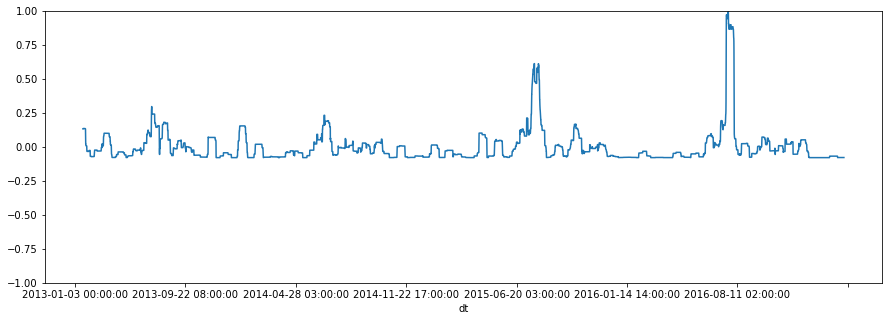

In [8]:
import matplotlib.pyplot as plt
df.groupby('dt').mean()['RAIN'].rolling(360).mean().plot(figsize=(15, 5))
plt.ylim(-1, 1)

## Create Machine Learning Model for PM2.5

In [9]:
time_index=pd.to_datetime(df['dt'])
df_kl=df.set_index(time_index)
df_kl.index

DatetimeIndex(['2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               '2013-01-03 00:00:00', '2013-01-03 00:00:00',
               ...
               '2017-12-02 23:00:00', '2017-12-02 23:00:00',
               '2017-12-02 23:00:00', '2017-12-02 23:00:00',
               '2017-12-02 23:00:00', '2017-12-02 23:00:00',
               '2017-12-02 23:00:00', '2017-12-02 23:00:00',
               '2017-12-02 23:00:00', '2017-12-02 23:00:00'],
              dtype='datetime64[ns]', name='dt', length=383586, freq=None)

In [10]:
df_kl=df.drop('dt', axis=1)
y = df_kl['PM2.5']
X = df_kl.drop(columns= ['PM2.5'])
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False)

In [21]:
y.mean()

79.52374434937668

In [22]:
model=tf.keras.models.Sequential()
layer_1=tf.keras.layers.Dense(units=48, activation="relu", input_dim=9)
model.add(layer_1)
layer_2=tf.keras.layers.Dense(units=32, activation="relu", input_dim=9)
model.add(layer_2)
layer_2=tf.keras.layers.Dense(units=32, activation="relu", input_dim=9)
model.add(layer_2)
# layer_3=tf.keras.layers.Dense(units=1, activation="sigmoid", input_dim=9)
# model.add(layer_3)
output_layer=tf.keras.layers.Dense(units=1)
model.add(output_layer)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 48)                480       
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1568      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 3,137
Trainable params: 3,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=200)

Epoch 1/200
8991/8991 [==============================] - 17s 2ms/step - loss: 486.2079 - mean_squared_error: 486.2079
Epoch 2/200
8991/8991 [==============================] - 17s 2ms/step - loss: 484.0847 - mean_squared_error: 484.0847
Epoch 3/200
8991/8991 [==============================] - 17s 2ms/step - loss: 482.1405 - mean_squared_error: 482.1405
Epoch 4/200
8991/8991 [==============================] - 17s 2ms/step - loss: 479.0704 - mean_squared_error: 479.0704
Epoch 5/200
8991/8991 [==============================] - 17s 2ms/step - loss: 477.4601 - mean_squared_error: 477.4601
Epoch 6/200
8991/8991 [==============================] - 20s 2ms/step - loss: 475.9463 - mean_squared_error: 475.9463
Epoch 7/200
8991/8991 [==============================] - 17s 2ms/step - loss: 472.6701 - mean_squared_error: 472.6701
Epoch 8/200
8991/8991 [==============================] - 16s 2ms/step - loss: 471.4205 - mean_squared_error: 471.4205 1s - l
Epoch 9/200
8991/8991 [==========================

In [ ]:
## Save Model
model.save('Models/pm25_model.h5')

## Create Time Series Models for each variable

array([[<AxesSubplot:title={'center':'PM2.5'}>,
        <AxesSubplot:title={'center':'PM10'}>,
        <AxesSubplot:title={'center':'SO2'}>],
       [<AxesSubplot:title={'center':'NO2'}>,
        <AxesSubplot:title={'center':'CO'}>,
        <AxesSubplot:title={'center':'O3'}>],
       [<AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'PRES'}>,
        <AxesSubplot:title={'center':'DEWP'}>],
       [<AxesSubplot:title={'center':'RAIN'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

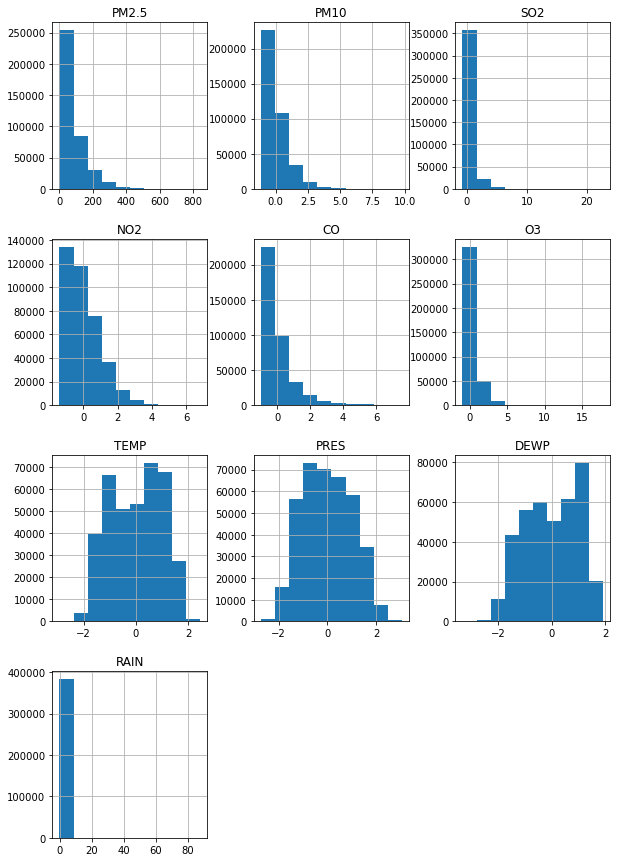

In [13]:
df.hist(figsize=(10, 15))

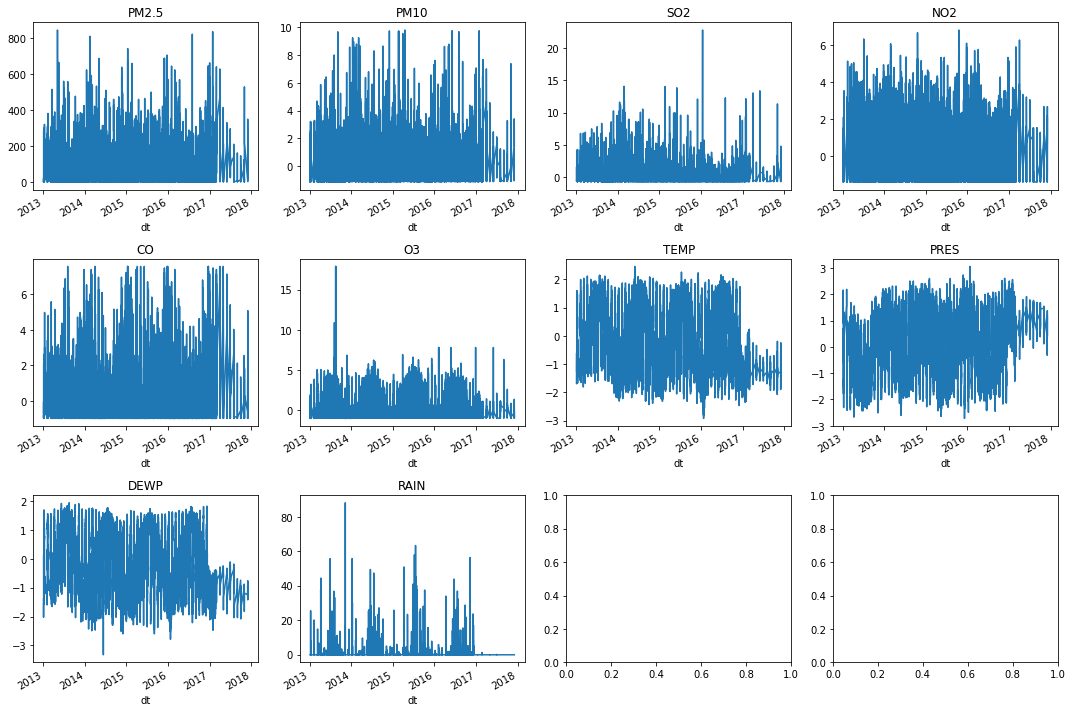

In [14]:
df=df.set_index(pd.to_datetime(df['dt']))
df = df.drop(columns = ['dt'])
fig, ax=plt.subplots(3, 4, figsize=(15, 10))

for idx, each_col in enumerate(df.columns): 
    if idx>=10: 
        break
    row_idx=idx//4
    col_idx=idx%4
    df[each_col].plot(ax=ax[row_idx][col_idx])
    ax[row_idx][col_idx].set_title(each_col)
plt.tight_layout()

In [15]:
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN
dt,,,,,,,,,,
2013-01-03,4.0,-1.101254,-0.545907,-1.243556,-0.804110,0.348630,-1.242142,1.164563,-1.538262,-0.078906
2013-01-03,9.0,-1.046543,-0.592877,-0.958503,-0.804110,0.560363,-1.224639,1.308088,-1.726789,-0.078906
2013-01-03,4.0,-1.101254,-0.076203,-0.872987,-0.804110,0.207475,-1.242142,1.164563,-1.538262,-0.078906
2013-01-03,7.0,-1.068428,-0.592877,-1.386082,-0.976692,0.595652,-1.382164,0.906219,-1.676032,-0.078906
2013-01-03,5.0,-0.991832,-0.545907,-1.101029,-0.890401,0.489786,-1.224639,1.308088,-1.726789,-0.078906


<AxesSubplot:xlabel='dt'>

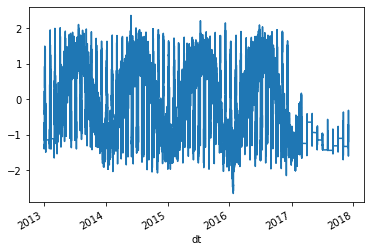

In [16]:
df['TEMP'].rolling(30).median().plot()

In [17]:
grouped_df=df.groupby('dt').mean()
grouped_df['TEMP'].head()

dt
2013-01-03 00:00:00   -1.257894
2013-01-03 01:00:00   -1.269368
2013-01-03 02:00:00   -1.335490
2013-01-03 03:00:00   -1.341907
2013-01-03 04:00:00   -1.378663
Name: TEMP, dtype: float64

### Create SO2 timeseries

In [18]:
import math
temp_arr=grouped_df['SO2'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [19]:
test_arr.shape

(8705, 1)

In [20]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [21]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [22]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [23]:
## So one big array with 365 smaller arrays within, each with 8340 individual single-value arrays within 

In [24]:
X_test

array([[[ 0.49918367],
        [ 0.28674956],
        [ 0.32090982],
        ...,
        [ 0.72229286],
        [ 0.87103232],
        [ 1.12936928]],

       [[ 0.28674956],
        [ 0.32090982],
        [ 0.00208073],
        ...,
        [ 0.87103232],
        [ 1.12936928],
        [ 1.2193958 ]],

       [[ 0.32090982],
        [ 0.00208073],
        [-0.1740581 ],
        ...,
        [ 1.12936928],
        [ 1.2193958 ],
        [ 1.29376553]],

       ...,

       [[ 0.07751797],
        [ 0.22696911],
        [ 0.37642024],
        ...,
        [ 1.22331   ],
        [ 1.01585759],
        [ 0.98845821]],

       [[ 0.22696911],
        [ 0.37642024],
        [ 0.29564546],
        ...,
        [ 1.01585759],
        [ 0.98845821],
        [ 0.91408848]],

       [[ 0.37642024],
        [ 0.29564546],
        [ 0.24831927],
        ...,
        [ 0.98845821],
        [ 0.91408848],
        [ 1.01977179]]])

In [25]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 365, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [26]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 187s 230ms/step - loss: 0.1148 - mean_squared_error: 0.1148
Epoch 2/5
805/805 [==============================] - 185s 230ms/step - loss: 0.0591 - mean_squared_error: 0.0591
Epoch 3/5
805/805 [==============================] - 173s 215ms/step - loss: 0.0586 - mean_squared_error: 0.0586
Epoch 4/5
805/805 [==============================] - 184s 228ms/step - loss: 0.0578 - mean_squared_error: 0.0578
Epoch 5/5
805/805 [==============================] - 186s 231ms/step - loss: 0.0577 - mean_squared_error: 0.0577


In [27]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

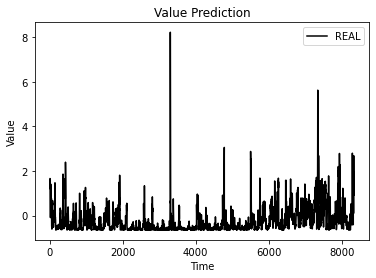

In [28]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

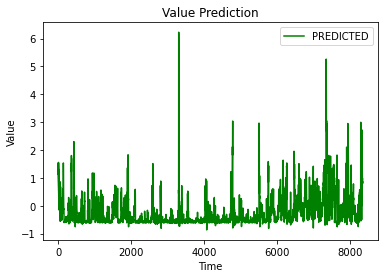

In [29]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [30]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 56s 213ms/step - loss: 0.0262 - mean_squared_error: 0.0262
Epoch 2/2
261/261 [==============================] - 55s 212ms/step - loss: 0.0259 - mean_squared_error: 0.0259


In [31]:
## Save Model
# lstm_model.save('Models/so3_model.h5')

### Create CO Time Series Model

In [32]:
temp_arr=grouped_df['CO'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [33]:
test_arr.shape

(8705, 1)

In [34]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [35]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [36]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [37]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 187s 230ms/step - loss: 0.1045 - mean_squared_error: 0.1045
Epoch 2/5
805/805 [==============================] - 172s 214ms/step - loss: 0.0646 - mean_squared_error: 0.0646
Epoch 3/5
805/805 [==============================] - 179s 223ms/step - loss: 0.0625 - mean_squared_error: 0.0625
Epoch 4/5
805/805 [==============================] - 181s 225ms/step - loss: 0.0614 - mean_squared_error: 0.0614
Epoch 5/5
805/805 [==============================] - 173s 215ms/step - loss: 0.0609 - mean_squared_error: 0.0609


In [39]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

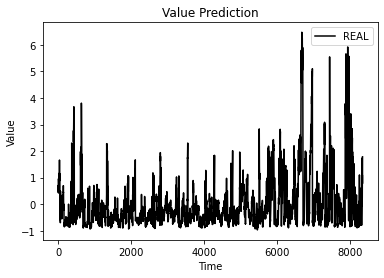

In [40]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

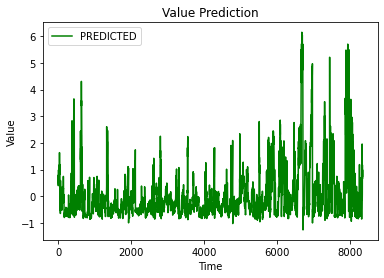

In [41]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [42]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 60s 229ms/step - loss: 0.0718 - mean_squared_error: 0.0718
Epoch 2/2
261/261 [==============================] - 56s 213ms/step - loss: 0.0695 - mean_squared_error: 0.0695


In [43]:
## Save Model
# lstm_model.save('Models/co_model.h5')

### Create DEWP Time Series Model

In [44]:
temp_arr=grouped_df['DEWP'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [45]:
test_arr.shape

(8705, 1)

In [46]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [47]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [48]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [49]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [50]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 192s 235ms/step - loss: 0.0414 - mean_squared_error: 0.0414
Epoch 2/5
805/805 [==============================] - 173s 215ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 3/5
805/805 [==============================] - 180s 223ms/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 4/5
805/805 [==============================] - 179s 223ms/step - loss: 0.0188 - mean_squared_error: 0.0188
Epoch 5/5
805/805 [==============================] - 174s 216ms/step - loss: 0.0187 - mean_squared_error: 0.0187


In [51]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

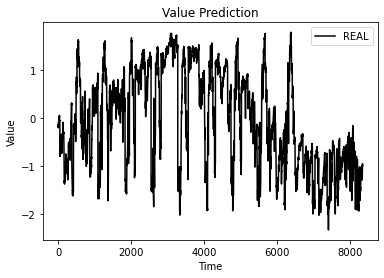

In [52]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

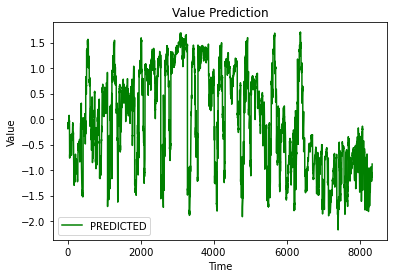

In [53]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [54]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 59s 228ms/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 2/2
261/261 [==============================] - 56s 214ms/step - loss: 0.0187 - mean_squared_error: 0.0187


In [55]:
## Save Model
# lstm_model.save('Models/dewp_model.h5')

### Create NO2 Time Series Model

In [56]:
temp_arr=grouped_df['NO2'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [57]:
test_arr.shape

(8705, 1)

In [58]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [59]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [60]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [61]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_9 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [62]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 174s 214ms/step - loss: 0.0845 - mean_squared_error: 0.0845
Epoch 2/5
805/805 [==============================] - 180s 224ms/step - loss: 0.0551 - mean_squared_error: 0.0551
Epoch 3/5
805/805 [==============================] - 183s 227ms/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 4/5
805/805 [==============================] - 179s 223ms/step - loss: 0.0534 - mean_squared_error: 0.0534
Epoch 5/5
805/805 [==============================] - 175s 217ms/step - loss: 0.0525 - mean_squared_error: 0.0525


In [63]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

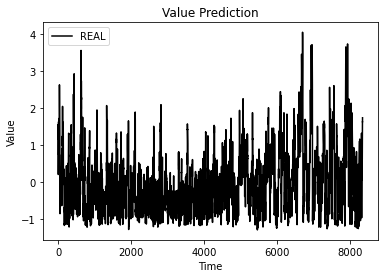

In [64]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

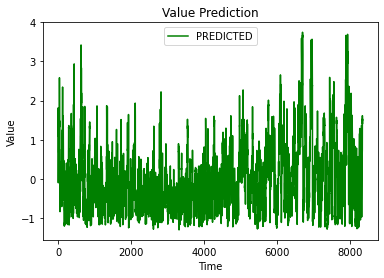

In [65]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [66]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 60s 230ms/step - loss: 0.0476 - mean_squared_error: 0.0476
Epoch 2/2
261/261 [==============================] - 59s 228ms/step - loss: 0.0471 - mean_squared_error: 0.0471


In [67]:
## Save Model
# lstm_model.save('Models/no2_model.h5')

### Create O3 time series model

In [68]:
temp_arr=grouped_df['O3'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [69]:
test_arr.shape

(8705, 1)

In [70]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [71]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [72]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [73]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 365, 50)           10400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_11 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [74]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 182s 223ms/step - loss: 0.0727 - mean_squared_error: 0.0727
Epoch 2/5
805/805 [==============================] - 177s 220ms/step - loss: 0.0325 - mean_squared_error: 0.0325
Epoch 3/5
805/805 [==============================] - 188s 233ms/step - loss: 0.0310 - mean_squared_error: 0.0310
Epoch 4/5
805/805 [==============================] - 181s 224ms/step - loss: 0.0304 - mean_squared_error: 0.0304
Epoch 5/5
805/805 [==============================] - 174s 217ms/step - loss: 0.0298 - mean_squared_error: 0.0298


In [75]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

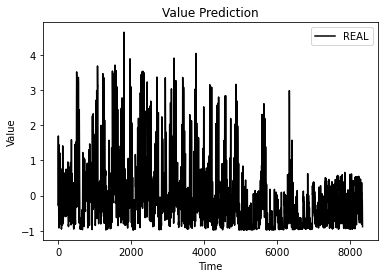

In [76]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

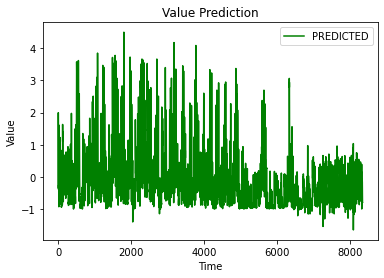

In [77]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [78]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 62s 239ms/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 2/2
261/261 [==============================] - 56s 214ms/step - loss: 0.0293 - mean_squared_error: 0.0293


In [79]:
## Save Model
# lstm_model.save('Models/o3_model.h5')

### Create pm10 time series model

In [80]:
temp_arr=grouped_df['PM10'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [81]:
test_arr.shape

(8705, 1)

In [82]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [83]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [84]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [85]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_13 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [86]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 184s 226ms/step - loss: 0.1051 - mean_squared_error: 0.1051
Epoch 2/5
805/805 [==============================] - 192s 239ms/step - loss: 0.0714 - mean_squared_error: 0.0714
Epoch 3/5
805/805 [==============================] - 185s 230ms/step - loss: 0.0704 - mean_squared_error: 0.0704
Epoch 4/5
805/805 [==============================] - 187s 233ms/step - loss: 0.0701 - mean_squared_error: 0.0701
Epoch 5/5
805/805 [==============================] - 190s 236ms/step - loss: 0.0688 - mean_squared_error: 0.0688


In [87]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

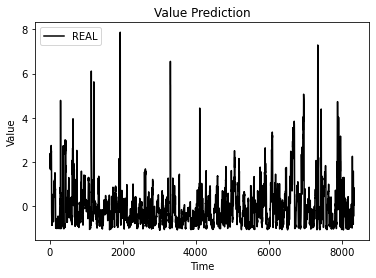

In [88]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

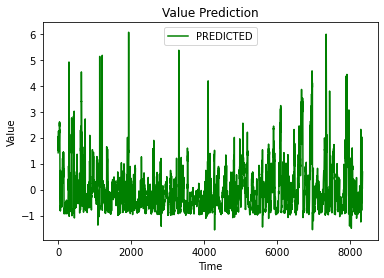

In [89]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [90]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 57s 219ms/step - loss: 0.0764 - mean_squared_error: 0.0764
Epoch 2/2
261/261 [==============================] - 57s 218ms/step - loss: 0.0764 - mean_squared_error: 0.0764


In [91]:
## Save Model
# lstm_model.save('Models/pm10_model.h5')

### Create PRES time series model

In [92]:
temp_arr=grouped_df['PRES'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [93]:
test_arr.shape

(8705, 1)

In [94]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [95]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [96]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [97]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_15 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [98]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 192s 235ms/step - loss: 0.0476 - mean_squared_error: 0.0476
Epoch 2/5
805/805 [==============================] - 185s 230ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 3/5
805/805 [==============================] - 180s 224ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 4/5
805/805 [==============================] - 186s 231ms/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 5/5
805/805 [==============================] - 187s 233ms/step - loss: 0.0207 - mean_squared_error: 0.0207


In [99]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

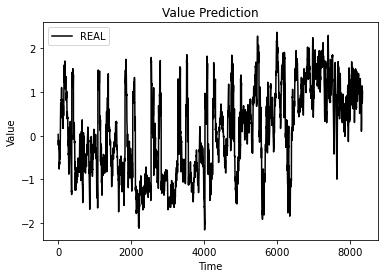

In [100]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

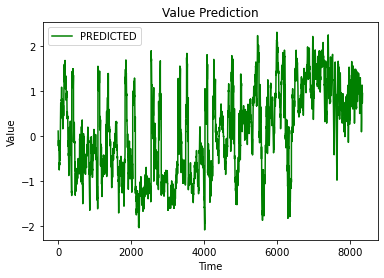

In [101]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [102]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 57s 218ms/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 2/2
261/261 [==============================] - 57s 217ms/step - loss: 0.0190 - mean_squared_error: 0.0190


In [103]:
## Save Model
# lstm_model.save('Models/pres_model.h5')

### Create TEMP time series model

In [104]:
temp_arr=grouped_df['TEMP'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [105]:
test_arr.shape

(8705, 1)

In [106]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [107]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [108]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [109]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_17 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [110]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 189s 232ms/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 2/5
805/805 [==============================] - 185s 230ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 3/5
805/805 [==============================] - 178s 221ms/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 4/5
805/805 [==============================] - 187s 232ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 5/5
805/805 [==============================] - 188s 234ms/step - loss: 0.0151 - mean_squared_error: 0.0151


In [111]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

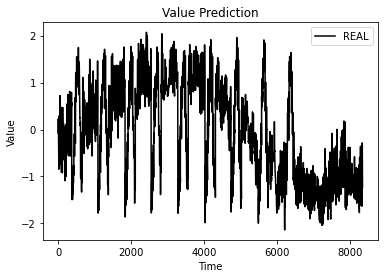

In [112]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

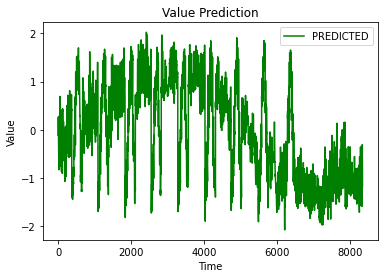

In [113]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [114]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 58s 220ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 2/2
261/261 [==============================] - 57s 219ms/step - loss: 0.0164 - mean_squared_error: 0.0164


In [115]:
## Save Model
# lstm_model.save('Models/temp_model.h5')

### Create RAIN time series model

In [126]:
temp_arr=grouped_df['RAIN'].values.reshape(-1, 1)
train_arr=temp_arr[0: math.ceil(.75*len(temp_arr))]
test_arr = temp_arr[math.ceil(.75*len(temp_arr)):]
train_arr.shape

(26116, 1)

In [127]:
days_season=365
X_train=[]
y_train=[]
X_test = []
y_test = []
for i in range(days_season, len(train_arr)): 
    X_train.append(train_arr[i-days_season: i, 0])
    y_train.append(train_arr[i, 0])
for i in range(days_season, len(test_arr)): 
    X_test.append(test_arr[i-days_season: i, 0])
    y_test.append(test_arr[i, 0])

In [128]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(25751, 365, 1)

In [129]:
X_test=np.array(X_test)
y_test=np.array(y_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(8340, 365, 1)

In [130]:
lstm_model=tf.keras.models.Sequential()
lstm_layer_1=tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(365, 1))
lstm_model.add(lstm_layer_1)
lstm_layer_2=tf.keras.layers.LSTM(50, return_sequences=False)
lstm_model.add(lstm_layer_2)
lstm_layer_3=tf.keras.layers.Dense(25)
lstm_model.add(lstm_layer_3)
lstm_output_layer=tf.keras.layers.Dense(1)
lstm_model.add(lstm_output_layer)
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 365, 50)           10400     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_19 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [131]:
lstm_model.compile(optimizer='adam', metrics=['mean_squared_error'], loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
805/805 [==============================] - 243s 296ms/step - loss: 0.3600 - mean_squared_error: 0.3600
Epoch 2/5
805/805 [==============================] - 233s 289ms/step - loss: 0.3218 - mean_squared_error: 0.3218
Epoch 3/5
805/805 [==============================] - 233s 290ms/step - loss: 0.3175 - mean_squared_error: 0.3175
Epoch 4/5
805/805 [==============================] - 241s 299ms/step - loss: 0.3281 - mean_squared_error: 0.3281
Epoch 5/5
805/805 [==============================] - 227s 282ms/step - loss: 0.3195 - mean_squared_error: 0.3195


In [132]:
## Now predict on test data 
y_predicted = lstm_model.predict(X_test)
y_real = y_test

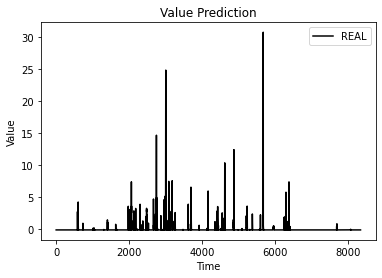

In [133]:
plt.plot(y_real, color = 'black', label = 'REAL')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

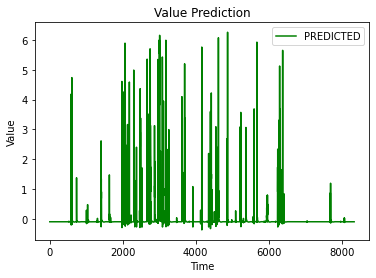

In [134]:
plt.plot(y_predicted, color = 'green', label = 'PREDICTED')
plt.title('Value Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [135]:
## Now let's test on our test data
lstm_model.fit(X_test, y_test, epochs=2)

Epoch 1/2
261/261 [==============================] - 62s 238ms/step - loss: 0.5122 - mean_squared_error: 0.5122
Epoch 2/2
261/261 [==============================] - 67s 259ms/step - loss: 0.4167 - mean_squared_error: 0.4167


In [136]:
## Save Model
# lstm_model.save('Models/rain_model.h5')